## BIBLIOTHÈQUES ET CONSTANTES

In [42]:
%matplotlib inline
from keras.applications import vgg16
from keras.models import Model, Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras.optimizers import RMSprop
import numpy as np
from numpy.random import permutation
import bcolz
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt

In [43]:
DATA_PATH = "../data/statefarm/"
#DATA_PATH = "../data/statefarm/sample/"
MODELS_PATH = "../data/statefarm/models/"
RESULTS_PATH = %pwd
RESULTS_PATH = RESULTS_PATH+'/results/'
% pwd

'/home/pierre/state-farm'

## VISUALISATION DES DONNÉES

In [31]:
VIS_PATH = "../data/statefarm/sample/"

In [27]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [33]:
gen = image.ImageDataGenerator()
# model.predict a aussi besoin de données sous forme de numpy array.
batches = gen.flow_from_directory(VIS_PATH+'train', target_size=(224, 224), class_mode=None,
                                 shuffle=False, batch_size=1)
train_data = np.concatenate([batches.next() for i in range(batches.samples)])
filenames = batches.filenames

Found 500 images belonging to 10 classes.


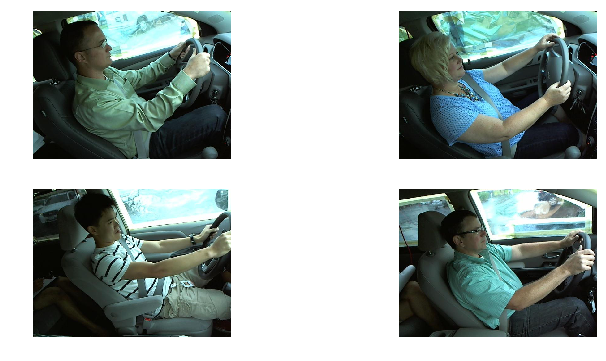

In [47]:
# CLASSE C0: conducteur attentif
idx = np.where(batches.classes==0)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

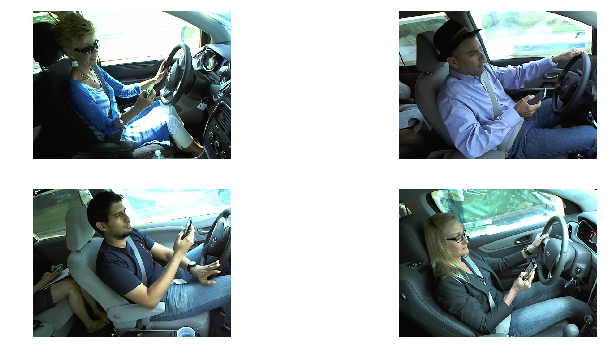

In [32]:
# CLASSE C1: texto main droite
idx = np.where(batches.classes==1)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

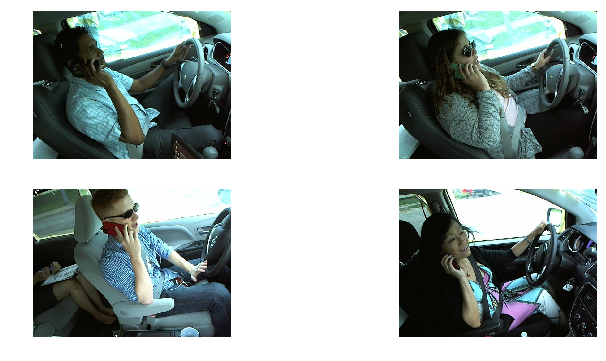

In [33]:
# CLASSE C2: appel oreille droite
idx = np.where(batches.classes==2)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

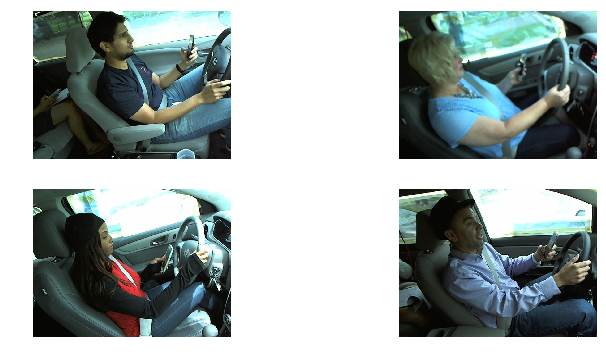

In [34]:
# CLASSE C3: texto main gauche
idx = np.where(batches.classes==3)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

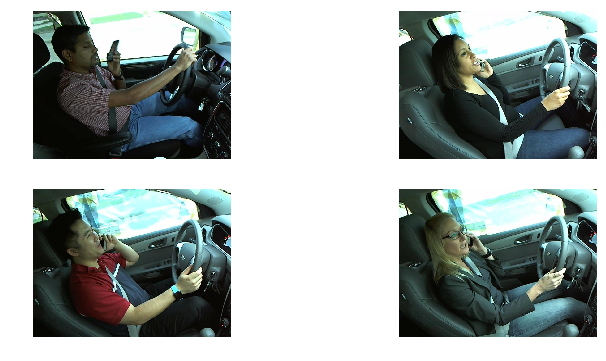

In [35]:
# CLASSE C4: appel oreille gauche
idx = np.where(batches.classes==4)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

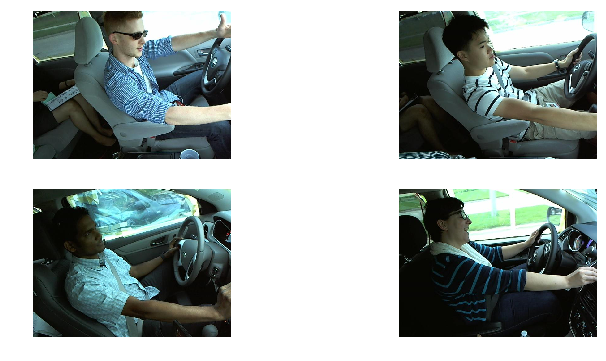

In [36]:
# CLASSE C5: radio
idx = np.where(batches.classes==5)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

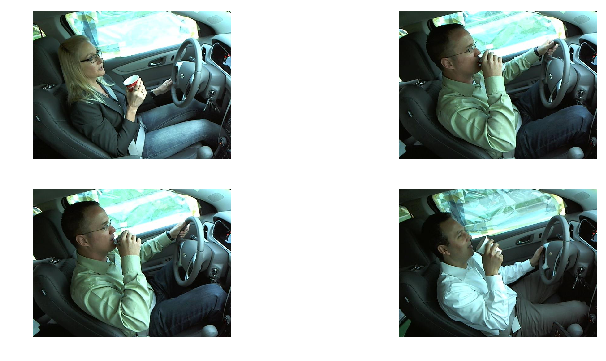

In [37]:
# CLASSE C6: boisson
idx = np.where(batches.classes==6)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

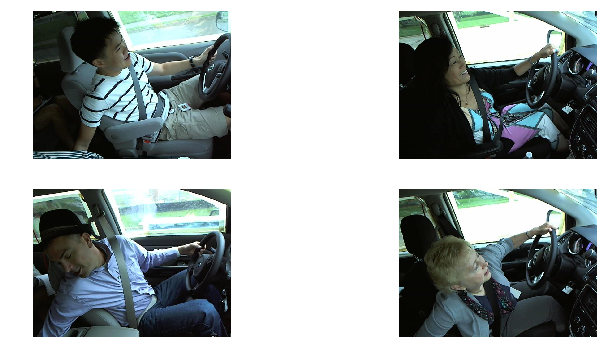

In [38]:
# CLASSE C7: attrappe qqch à l'arrière
idx = np.where(batches.classes==7)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

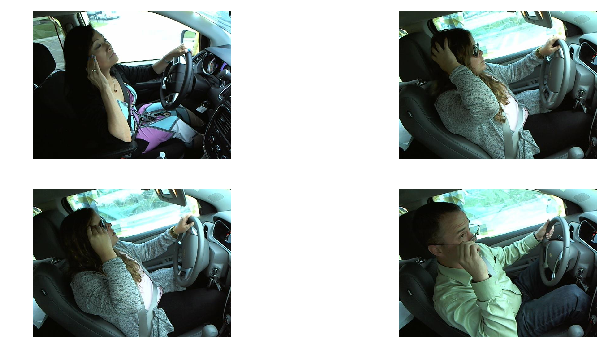

In [39]:
# CLASSE C8: se recoiffe
idx = np.where(batches.classes==8)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][:4]], rows=2)

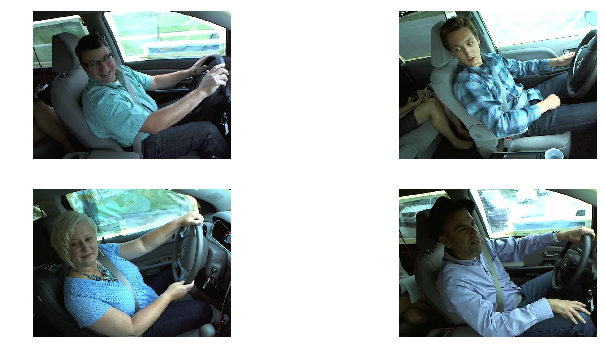

In [38]:
# CLASSE C9: conducteur inattentif/discute ?
idx = np.where(batches.classes==9)
plots([image.load_img(DATA_PATH+'train/'+filenames[i]) for i in idx[0][8:12]], rows=2)

## RÉCUPÉRATION DU MODÈLE VGG16 SANS LES COUCHES DENSES

In [44]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None,
                  input_shape=(224, 224, 3))

In [45]:
for layer in vgg.layers: layer.trainable=False

In [46]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## FINETUNING

### Création du modèle de finetuning

In [47]:
x = vgg.output

In [48]:
x = Flatten(input_shape=vgg.output_shape[1:])(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(10, activation='softmax')(x)

### Fusion avec le réseau de convolution VGG16

In [49]:
model = Model(inputs=vgg.input, outputs=predictions)

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [51]:
opt = RMSprop(lr=0.00001)

In [52]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## TRAITEMENT DES DONNÉES

### Création des flux de lots d'images

In [53]:
gen = image.ImageDataGenerator()
trn_batches = gen.flow_from_directory(DATA_PATH+'train', target_size=(224, 224), 
                                      class_mode='categorical', shuffle=False, batch_size=1)
val_batches = gen.flow_from_directory(DATA_PATH+'valid', target_size=(224, 224),
                                     class_mode='categorical', shuffle=False, batch_size=1)

Found 22424 images belonging to 10 classes.
Found 2239 images belonging to 10 classes.


### Concaténation des données des images

In [36]:
batches = gen.flow_from_directory(DATA_PATH+'train', target_size=(224, 224), class_mode=None,
                                 shuffle=False, batch_size=1)
trn_data = np.concatenate([batches.next() for i in range(batches.samples)])
batches = gen.flow_from_directory(DATA_PATH+'valid', target_size=(224, 224), class_mode=None,
                                 shuffle=False, batch_size=1)
val_data = np.concatenate([batches.next() for i in range(batches.samples)])

Found 22424 images belonging to 10 classes.
Found 2239 images belonging to 10 classes.


### Sauvegarde du format créé

In [37]:
c = bcolz.carray(trn_data, rootdir=MODELS_PATH+'train_data.bc', mode='w')
c.flush()
c = bcolz.carray(val_data, rootdir=MODELS_PATH+'valid_data.bc', mode='w')
c.flush()

### Récupération des données concaténées

In [54]:
trn_data = bcolz.open(MODELS_PATH+'train_data.bc')[:]
val_data = bcolz.open(MODELS_PATH+'valid_data.bc')[:]

### Labels correspondant aux données

In [55]:
trn_classes = trn_batches.classes
val_classes = val_batches.classes

trn_labels = np.array(OneHotEncoder().fit_transform(trn_classes.reshape(-1, 1)).todense())
val_labels = np.array(OneHotEncoder().fit_transform(val_classes.reshape(-1, 1)).todense())

## APPRENTISSAGE

In [ ]:
batch_size = 16
gen = image.ImageDataGenerator()
trn_batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=True)

In [ ]:
nb_epochs = 2
model.fit_generator(trn_batches, steps_per_epoch=trn_batches.n/batch_size, epochs=nb_epochs,
                    validation_data=val_batches, validation_steps=val_batches.n/batch_size)

Epoch 1/2
 938/1401 [===================>..........] - ETA: 3123s - loss: 1.3272 - acc: 0.5706

In [ ]:
model.save_weights(MODELS_PATH+'vgg_from_keras_batchnorm.h5')

## VÉRIFICATION

In [56]:
model.load_weights(MODELS_PATH+'vgg_from_keras_batchnorm.h5')

In [57]:
model.evaluate(val_data, val_labels)

2239/2239 [==============================] - 551s     

[0.024036677549258308, 0.99374720817594031]

In [ ]:
model.evaluate(trn_data, trn_labels)

In [66]:
model.metrics_names

['loss', 'acc']

#### Avec evaluate_generator()

In [65]:
gen = image.ImageDataGenerator()
batch_size = 64
valid_generator = gen.flow_from_directory(DATA_PATH+'valid', target_size=(224, 224),
                                         class_mode='categorical', batch_size=batch_size)

Found 2239 images belonging to 10 classes.


In [ ]:
model.evaluate_generator(valid_generator, int(np.ceil(valid_generator.n/batch_size)), workers=)

## PRÉDICTIONS

### En utilisant model.predict()

In [40]:
gen = image.ImageDataGenerator()
# model.predict a aussi besoin de données sous forme de numpy array.
batches = gen.flow_from_directory(DATA_PATH+'test_small', target_size=(224, 224), class_mode=None,
                                 shuffle=False, batch_size=1)
test_data = np.concatenate([batches.next() for i in range(batches.samples)])
filenames = batches.filenames

Found 1000 images belonging to 1 classes.


In [ ]:
# sauvegarde des données et nom des fichiers
c = bcolz.carray(test_data, rootdir=RESULTS_PATH+'test_data.bc', mode='w')
c.flush()
c=bcolz.carray(filenames, rootdir=RESULTS_PATH+'test_filenames.dat', mode='w')
c.flush()

In [8]:
test_data = bcolz.open(RESULTS_PATH+'test_data.bc')[:]
filenames = bcolz.open(RESULTS_PATH+'test_filenames.dat')[:]

FileNotFoundError: [Errno 2] No such file or directory: '/home/pierre/state-farm/results/test_data.bc/meta/sizes'

In [18]:
# calcul des prédictions
preds = model.predict(test_data, batch_size=128, verbose=1)

1000/1000 [==============================] - 243s     


In [19]:
# Sauvegarde des prédictions
c=bcolz.carray(preds, rootdir=RESULTS_PATH+'test_preds.dat', mode='w')
c.flush()

#### Visualisation

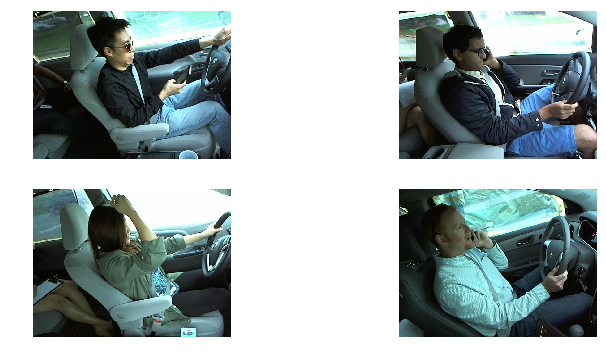

In [41]:
plots([image.load_img(DATA_PATH+'test_small/'+filenames[i]) for i in range(4)], rows=2)

In [34]:
predictions[:4]

array([[  1.14455426e-04,   9.90387489e-05,   2.61712248e-05,
          1.69192299e-05,   3.99660226e-03,   4.41082375e-05,
          4.88588121e-05,   1.99897841e-04,   9.89650190e-01,
          5.80374151e-03],
       [  1.08020706e-03,   2.62087472e-02,   7.35908151e-02,
          7.00423552e-05,   5.13382663e-04,   1.61210971e-03,
          2.01744770e-04,   8.53019953e-02,   8.09421241e-01,
          1.99968508e-03],
       [  2.58140583e-02,   6.53793216e-02,   1.40874118e-01,
          6.21847794e-05,   7.84011856e-02,   2.48634443e-02,
          5.87251186e-02,   8.05942155e-03,   5.76680005e-01,
          2.11411230e-02],
       [  5.83418667e-01,   1.39131984e-02,   8.12652346e-04,
          7.45595200e-03,   6.27025357e-03,   5.84997283e-03,
          1.17642935e-02,   1.69446152e-02,   4.27279882e-02,
          3.10842425e-01]], dtype=float32)

### En utilisant model.predict_generator()

In [59]:
gen = image.ImageDataGenerator()
batch_size = 64
test_generator = gen.flow_from_directory(DATA_PATH+'test', target_size=(224, 224),
                                         class_mode='categorical', batch_size=batch_size)

Found 79726 images belonging to 1 classes.


In [60]:
filenames = test_generator.filenames
c=bcolz.carray(filenames, rootdir=RESULTS_PATH+'test_filenames.dat', mode='w')
c.flush()

In [1]:
#predictions = model.predict_generator(test_generator, int(np.ceil(test_generator.n/batch_size)))

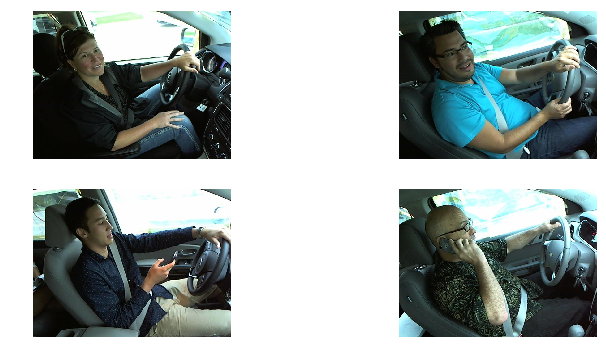

In [61]:
plots([image.load_img(DATA_PATH+'test/'+test_generator.filenames[i]) for i in range(50,54)], rows=2)

In [65]:
predictions[50:54]

array([[  2.31378525e-02,   7.31464569e-03,   1.77876966e-03,
          2.28091539e-03,   7.52875407e-04,   1.58708461e-03,
          1.77304950e-02,   6.73892675e-03,   4.14053984e-02,
          8.97273064e-01],
       [  1.04259243e-02,   7.37028167e-05,   3.71543933e-06,
          3.35654477e-04,   4.50855223e-05,   1.83215423e-04,
          5.14838985e-06,   4.58098439e-05,   3.17249055e-06,
          9.88878548e-01],
       [  3.90853384e-04,   9.77015316e-01,   1.20498553e-04,
          8.19732028e-04,   8.52564481e-05,   4.96217050e-04,
          4.28941147e-03,   1.67618576e-03,   1.34878578e-02,
          1.61868648e-03],
       [  2.65577073e-05,   3.19861392e-05,   9.82875764e-01,
          1.98801263e-05,   5.00248825e-05,   2.46969212e-05,
          1.55027676e-02,   1.94168359e-04,   1.24121644e-03,
          3.29536197e-05]], dtype=float32)

## Soumission des prédictions à Kaggle

In [149]:
predictions = bcolz.open(RESULTS_PATH+'test_predictions.dat')[:]
filenames = bcolz.open(RESULTS_PATH+'test_filenames.dat')[:]

In [150]:
predictions.shape

(79726, 10)

In [151]:
filenames.shape

(79726,)

In [152]:
#Plafonner les prédictions à 0.9999
predictions = predictions.clip(min=0.0001, max=0.9999)

In [153]:
filenames[0]

'unknown/img_86337.jpg'

In [154]:
filenames = np.array([f[8:] for f in filenames])

In [155]:
filenames[0]

'img_86337.jpg'

In [156]:
result = np.column_stack((filenames, predictions))

In [157]:
result[0]

array(['img_86337.jpg', '0.00011445542622823268', '9.999999747378752e-05',
       '9.999999747378752e-05', '9.999999747378752e-05',
       '0.003996602259576321', '9.999999747378752e-05',
       '9.999999747378752e-05', '0.0001998978405026719',
       '0.9896501898765564', '0.00580374151468277'], 
      dtype='<U32')

In [158]:
type(result[0][1])

numpy.str_

In [159]:
np.savetxt("submission_final_clipped_e-4.csv", result, fmt="%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s", header="img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9", comments='')

In [160]:
from IPython.display import FileLink
FileLink('submission_final_clipped_e-4.csv')

/home/pierre/state-farm/submission_final_clipped_e-4.csv